# ➕ Evaluation handling

In contrast to some machine learning frameworks that handle different behaviors of layers during training and evaluation with specific methods like `model.eval()` and `model.fit()`, `serket` offers a more explicit approach for managing this behavior. `serket` provides a function called `tree_eval`, which allows users to modify a tree of layers to disable any training-related behavior. The significant difference is that instead of modifying the layers in place `serket` replaces them with their evaluation counterparts.

For instance, during evaluation, the `Dropout` layer is replaced by an `Identity` layer, and the `BatchNorm` layer is replaced by an `EvalNorm` layer. This ensures that when evaluating a tree of layers, users can follow the **"What you see is what you get" (WYSIWYG)** principle, meaning that Seeing a `Dropout`/`BatchNorm` in the model have one meaning.

The following examle, train a sequential of layers with `Dropout` layer. then applies `tree_eval` to replace the `Dropout` with `Identity`

In [ ]:
!pip install git+https://github.com/ASEM000/serket --quiet

In [1]:
import serket as sk
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

net = sk.nn.Sequential(
    sk.nn.Linear(1, 50, weight_init="he_normal"),
    sk.nn.Dropout(0.125),
    jnp.tanh,
    sk.nn.Linear(50, 1),
)

net = sk.tree_mask(net)
x = jnp.linspace(-1, 1, 100)[..., None]
y = jnp.sin(x * 3.14)


@jax.jit
def train_step(net, x, y, key):
    keys = jax.random.split(key, len(x))

    def loss_func(net, x, y):
        net = sk.tree_unmask(net)
        ypred = jax.vmap(net)(x, key=keys)
        return jnp.mean((ypred - y) ** 2)

    grad = jax.grad(loss_func)(net, x, y)
    net = jax.tree_map(lambda p, g: p - 1e-3 * g, net, grad)
    return net


key = jax.random.PRNGKey(0)

for i in range(10_000):
    key,subkey = jax.random.split(key)
    net = train_step(net, x, y, subkey)

net = sk.tree_unmask(net)
print(repr(net))

Sequential(
  layers=(
    Linear(
      in_features=(1), 
      out_features=50, 
      weight_init=he_normal, 
      bias_init=zeros, 
      weight=f32[1,50](μ=0.20, σ=1.42, ∈[-2.93,2.55]), 
      bias=f32[50](μ=-0.00, σ=0.00, ∈[-0.00,0.00])
    ), 
    Dropout(drop_rate=f32[](μ=0.12, σ=0.00, ∈[0.12,0.12]), drop_axes=Ellipsis), 
    <PjitFunction of <function jax.numpy.tanh at 0x12c15f9c0>>, 
    Linear(
      in_features=(50), 
      out_features=1, 
      weight_init=glorot_uniform, 
      bias_init=zeros, 
      weight=f32[50,1](μ=-0.02, σ=0.10, ∈[-0.22,0.18]), 
      bias=f32[1](μ=-0.00, σ=0.00, ∈[-0.00,-0.00])
    )
  )
)


Apply `tree_eval`

Note how `Dropout` is replaced by `Identity`

In [2]:
net = sk.tree_eval(net)
print(repr(net))

Sequential(
  layers=(
    Linear(
      in_features=(1), 
      out_features=50, 
      weight_init=he_normal, 
      bias_init=zeros, 
      weight=f32[1,50](μ=0.20, σ=1.42, ∈[-2.93,2.55]), 
      bias=f32[50](μ=-0.00, σ=0.00, ∈[-0.00,0.00])
    ), 
    Identity(), 
    <PjitFunction of <function jax.numpy.tanh at 0x12c15f9c0>>, 
    Linear(
      in_features=(50), 
      out_features=1, 
      weight_init=glorot_uniform, 
      bias_init=zeros, 
      weight=f32[50,1](μ=-0.02, σ=0.10, ∈[-0.22,0.18]), 
      bias=f32[1](μ=-0.00, σ=0.00, ∈[-0.00,-0.00])
    )
  )
)


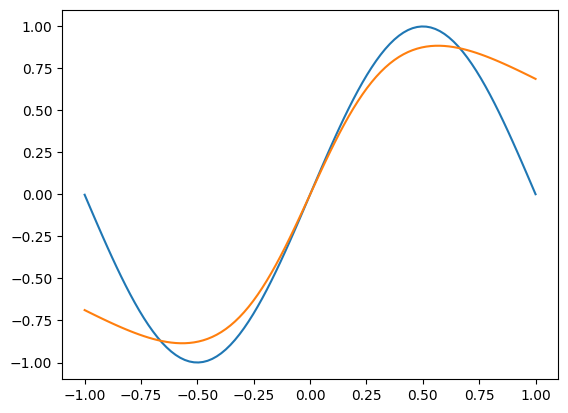

In [3]:
plt.plot(x, y, label="true")
plt.plot(x, jax.vmap(net)(x), label="pred")

**Define evaluation rule**

The following shows how to define an evaluation behavior for a layer that exhibits different behavior based on eval/train status.

In [4]:
import serket as sk
import jax


class AddOne(sk.TreeClass):
    def __call__(self, x: jax.Array) -> jax.Array:
        return x + 1


x = jax.numpy.ones([3, 3])

add_one = AddOne()


class AddOneEval(sk.TreeClass):
    def __call__(self, x: jax.Array) -> jax.Array:
        return x  # no-op


@sk.tree_eval.def_eval(AddOne)
def _(_: AddOne) -> AddOneEval:
    return AddOneEval()


print(add_one(x))
print(sk.tree_eval(add_one)(x))

[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
